In [1]:
from imports import *
from preprocessing_util import get_column_groups, get_transformers
from sklearn.pipeline import Pipeline
from sklearn. compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, f1_score, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate

In [2]:
query = "select * from train_data"
train_data = sql_connect(query)
X_train = train_data.drop(columns=['TARGET'])
y_train = train_data['TARGET']
del train_data
X_train.head()

Connection to SQL Server established successfully.
Connection closed.


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AVERAGE_EXTERNAL_RATING,TOT_PREV_APP,PREV_APPROVED_CNT,PREV_CANCELLED_CNT,PREV_REFUSED_CNT,PREV_UNUSED_CNT,ISMISSING_BUREAU_INFO
0,Cash loans,M,0,1,1,126000.0,545040.0,17244.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010966,-9470,-1114,-9301.0,-2142.0,-1,1,1,0,1,1,0,Drivers,3,2,2,TUESDAY,15,0,0,0,0,1,1,Business Entity Type 3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.5739,0,0,0,0,0,0
1,Cash loans,F,0,1,0,135000.0,269550.0,18760.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.035792,-24367,365243,-13226.0,-4579.0,-1,1,0,0,1,1,0,Retired,2,2,2,WEDNESDAY,15,0,0,0,0,0,0,NA,0,0,0,0,-1052,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.7012,0,0,0,0,0,1
2,Cash loans,M,0,0,0,270000.0,497520.0,33246.0,450000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.008474,-10739,-353,-1418.0,-1843.0,-1,1,1,1,1,0,0,Laborers,2,2,2,SUNDAY,11,1,1,0,1,1,0,Business Entity Type 2,0,0,0,0,-251,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.3572,0,0,0,0,0,0
3,Revolving loans,F,0,1,0,112500.0,315000.0,15750.0,315000.0,Family,Pensioner,Secondary / secondary special,Widow,House / apartment,0.035792,-21202,365243,-15132.0,-3152.0,-1,1,0,0,1,1,0,Retired,1,2,2,SATURDAY,11,0,0,0,0,0,0,NA,0,0,0,0,-551,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,2.0,8.0,0.5516,0,0,0,0,0,0
4,Revolving loans,F,1,1,2,225000.0,450000.0,22500.0,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.028663,-12341,-4904,-6217.0,-4151.0,24,1,1,0,1,0,0,Accountants,4,2,2,WEDNESDAY,11,0,0,0,1,0,1,Business Entity Type 2,0,0,0,0,-292,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.4927,0,0,0,0,0,0


In [5]:
column_groups = get_column_groups(X_train)
transformers = get_transformers(
    column_groups['log_col'],
    column_groups['scale_only_cols'],
    column_groups['categorical_cols']
)

In [6]:
preprocessor = ColumnTransformer(transformers=transformers)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
pipeline = Pipeline(
    [('preprocess', preprocessor),
    ('svm', SVC(kernel='rbf', class_weight='balanced'))]
)

In [7]:
scoring = {
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted'),
    'f1': make_scorer(f1_score, average='weighted')
}

In [12]:
model_1_cv = cross_validate(
    pipeline,
    X_train,
    y_train,
    cv=cv_strategy,
    scoring=scoring,
    n_jobs=-1,
    verbose=1,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.2min finished


In [ ]:
model_1_cv['test_recall']


array([0.74865672, 0.74462687, 0.74791045, 0.74936558, 0.74040902])

In [14]:
model_1_cv['test_precision']

array([0.87916329, 0.88556101, 0.88791542, 0.88539378, 0.88446809])

### model is performing is very indicating that the dat awas non linearly seperable with recall about 75 and preciosin 88 

Lets apply pca on the sdata to see if it help reduc ethe trainig time without losing precision

In [15]:
pipeline_2 = Pipeline(
    [('preprocess', preprocessor),
     ('pca', PCA(n_components=0.90)),
     ('svm', SVC(kernel='rbf', class_weight='balanced'))]
)

In [16]:
model_2_cv = cross_validate(
    pipeline_2,
    X_train,
    y_train,
    cv=cv_strategy,
    scoring=scoring,
    n_jobs=-1,
    verbose=1,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


In [17]:
model_2_cv['test_recall']

array([0.72686567, 0.72985075, 0.72507463, 0.72697418, 0.71607703])

In [18]:
model_2_cv['test_precision']

array([0.88314637, 0.88568265, 0.8869687 , 0.88745439, 0.88293749])

In [24]:
model_2_cv['fit_time']

array([40.99157405, 40.56038547, 40.92085862, 39.73880792, 39.96486092])

### The preciiosn stayed intact hwoever we lost a bit of recall

In [8]:
pipeline_3 = Pipeline(
    [('preprocess', preprocessor),
     ('pca', PCA(n_components=0.95)),
     ('svm', SVC(kernel='rbf', class_weight='balanced'))]
)

In [9]:
model_3_cv = cross_validate(
    pipeline_3,
    X_train,
    y_train,
    cv=cv_strategy,
    scoring=scoring,
    n_jobs=-1,
    verbose=1,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


In [10]:
model_3_cv['test_recall']

array([0.73820896, 0.73910448, 0.74104478, 0.74011046, 0.72563069])

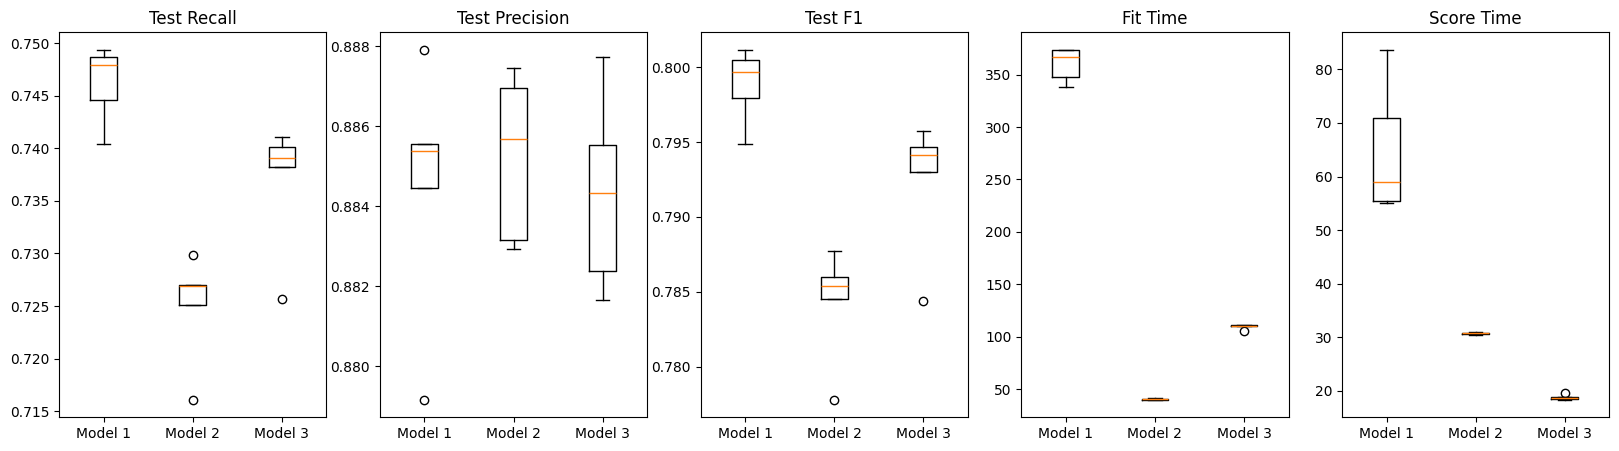

In [32]:
fig, axis = plt.subplots(1, 5, figsize=(20, 5))
axis = axis.flatten()
for i, metric in enumerate(['test_recall', 'test_precision', 'test_f1', 'fit_time', 'score_time']):
    axis[i].boxplot(
    [model_1_cv[metric], model_2_cv[metric], model_3_cv[metric]],
    tick_labels=['Model 1', 'Model 2', 'Model 3'])
    axis[i].set_title(metric.replace('_', ' ').title()
);




#### Model 1 has highest recall, which is out first priorty then precision is also more certain hwoever the fit time and score time is alot
#### Model 2 

### Choosing model 3

In [15]:
param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': [0, 0.01, 0.1, 1]
}

In [16]:
print("Starting Grid Search for Model 4...")
model_4_cv = GridSearchCV(
    pipeline_3, 
    param_grid,
    cv=cv_strategy,
    scoring=scoring,
    refit=scoring['recall'],
    n_jobs=-1,
    verbose=1,
)

model_4_cv.fit(X_train, y_train)
print("Best parameters found: ", model_4_cv.best_params_)

Starting Grid Search for Model 3...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(model_4_cv.cv_results_)

# Example: View available columns
print(results_df.columns)

In [ ]:
print("Starting Grid Search for Model 3...")
grid = GridSearchCV(pipeline_3, param_grid, cv=cv_strategy, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
model_3_best_param = grid.best_params_['model__C']
print(f"Best parameter for Model 3: {model_3_best_param}")
#print(grid.best_estimator_)